In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

all_df = pd.read_csv('TrainDataset2024.csv', index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,144.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,0,142.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median", missing_values=999)
all_df[:] = imputer.fit_transform(all_df)

# Assign features to X
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)
# classification target
clf_y = all_df['pCR (outcome)']
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']

In [11]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def mad_based_outlier(points, threshold=3.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:, None]
    median_y = np.median(points)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points])
    # Small constant added to avoid division by zero
    modified_z_scores = [0.6745 * (y - median_y) / (median_absolute_deviation_y + 1e-6) for y in points]

    return np.abs(modified_z_scores) > threshold

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if abs(val - mean)/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutliers(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = func(x)
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(20, 15)

def removeOutliers(data):
    # Remove outliers from the dataframe
    for column in data.columns:
        outliers = outlierVote(all_df[column])
        # Calculate Non-Outlier Maximum using the outliers list
        non_outlier_max = all_df.loc[~np.array(outliers), column].max()
        # Replace outliers with the maximum non-outlier value
        data.loc[outliers, column] = non_outlier_max

removeOutliers(all_df)
# Verify the changes
all_df.head()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,1,135.0,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.028820,0.000758
1,0,135.0,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,1,135.0,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,0,12.0,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,0,109.0,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


1. Feature 12 (0.207466)
2. Feature 11 (0.203157)
3. Feature 0 (0.192015)
4. Feature 10 (0.068132)
5. Feature 9 (0.064976)
6. Feature 3 (0.048714)
7. Feature 6 (0.047688)
8. Feature 8 (0.039438)
9. Feature 1 (0.032694)
10. Feature 5 (0.028711)
11. Feature 2 (0.027739)
12. Feature 4 (0.020453)
13. Feature 7 (0.018819)


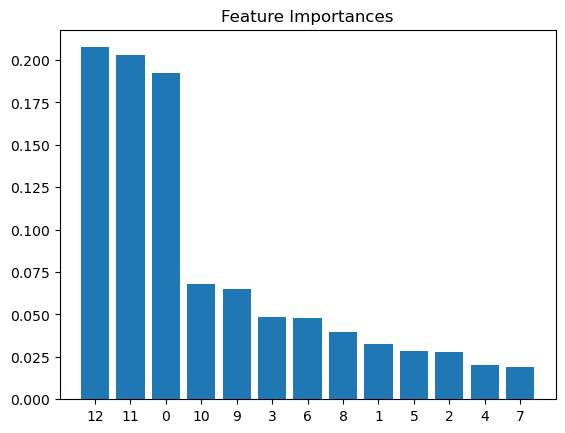

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Normalise the features to use zero mean normalisation
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Dimensionality Reduction using PCA to reduce features to 2 components
pca = PCA(n_components=2)

# USING PCA for all
#pca.fit(Xs)
#Xs = pca.transform(Xs)

# USING PCA for only the MRI data
Xs_pca = pca.fit_transform(Xs[:, 11:])
Xs = np.hstack((Xs[:, :11], Xs_pca))

rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
rnd_clf.fit(Xs, y)
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(Xs.shape[1]):
    print("%d. Feature %d (%f)" % (i + 1, indices[i], importances[indices[i]]))

plt.title('Feature Importances')
plt.bar(range(Xs.shape[1]), importances[indices], align='center')
plt.xticks(range(Xs.shape[1]), indices)
plt.xlim([-1, Xs.shape[1]])
plt.show()

Xs = Xs[:, indices[:9]]

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score

log_reg = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(log_reg, Xs, clf_y, cv=kf)

mean_score = np.mean(scores)

print("mean cross-validation accuracy: {:03.2f}".format(mean_score))

mean cross-validation accuracy: 0.80


In [14]:
# SVM for classification
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score

# K fold value
kf = KFold(n_splits=5, shuffle=True, random_state=1)

svm_clf = SVC(C=0.1, kernel="rbf", degree=3, gamma='auto')
svm_clf.fit(Xs, y)
scores = cross_val_score(svm_clf, Xs, clf_y, cv=kf)

avg = (100 * np.mean(scores), 100 * np.std(scores)/np.sqrt(scores.shape[0]))
print("Average fold score and standard deviation: (%.2f +- %.3f)%%" %avg)

Average fold score and standard deviation: (79.00 +- 0.548)%
